## Aprenentatge no supervisat
## S15 T01: Classifica els diferents vols
### Nivell 1
### Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-mean

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc


In [2]:
df =pd.read_csv('DelayedFlights.csv')

In [27]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


first steps
- Clean dataset
- impute missing values
- split the data between categorical and numerical
- preprocess the data

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace= True)

In [4]:
## I will take a random sample, impute missing values and then split the data by numerical and categorial 
smpl = df.shape[0]*0.10
df_sample = df.sample(int(smpl))
df_sample.shape[0]
df_sample[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']]=df_sample[['CarrierDelay'
                                                                                       ,'WeatherDelay'
                                                                                       ,'NASDelay',
                                                                                       'SecurityDelay',
                                                                                       'LateAircraftDelay']].fillna(0)
for feature in df_sample[['AirTime','ActualElapsedTime','CRSElapsedTime','ArrTime','TaxiIn','TaxiOut','ArrDelay']]:
    df_sample[feature].fillna(df_sample[feature].mean(),inplace=True)
    
numeric_data = df_sample.select_dtypes(include=[np.number])
categorical_data = df_sample.select_dtypes(exclude=[np.number])



In [5]:
## encoding  each place by the same code

encoding =categorical_data[['Origin','Dest']]
le= LabelEncoder()
le.fit(encoding.stack().unique())
encoding['OriginEnc'] = le.transform(encoding['Origin'])
encoding['DestEnc'] = le.transform(encoding['Dest'])

<ipython-input-5-69fcb2317ef0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoding['OriginEnc'] = le.transform(encoding['Origin'])
<ipython-input-5-69fcb2317ef0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoding['DestEnc'] = le.transform(encoding['Dest'])


In [31]:
encoding

,Origin,Dest,OriginEnc,DestEnc
149478,DFW,DAY,81,77
620288,LAX,TUS,156,285
111366,BWI,PWM,48,231
1851647,SDF,ATL,254,18
1648008,CLT,EWR,63,96
...,...,...,...,...
901966,HOU,DAL,130,76
647122,CLT,PIT,63,222
41815,CLE,CLT,61,63
557352,IAH,EWR,136,96


In [6]:
encoding.drop(['Origin','Dest'],axis=1,inplace=True)

C:\Users\adria\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
categorical_data= pd.concat([categorical_data,encoding],axis=1)

In [8]:
categorical_data.drop(['Origin','Dest'],axis=1,inplace=True)

In [9]:
## Encoding  the remain categorical features
categorical_data['UniqueCarrier']= le.fit_transform(categorical_data['UniqueCarrier'])


In [10]:
categorical_data['TailNum']=le.fit_transform(categorical_data['TailNum'])

In [11]:
categorical_data['CancellationCode']=le.fit_transform(categorical_data['TailNum'])


In [12]:
## transform time variables into cosinus series
categorical_data['Month'] = np.cos(2 * np.pi * df['Month']/df['Month'].max())
categorical_data['DayofMonth'] = np.cos(2 * np.pi * df['DayofMonth']/df['DayofMonth'].max())
categorical_data['DayOfWeek'] = np.cos(2 * np.pi * df['DayOfWeek']/df['DayOfWeek'].max())

In [13]:
numeric_data.drop(['Month','DayofMonth','DayOfWeek'],axis=1,inplace=True)

In [14]:
df_sample_processed = pd.concat([numeric_data,categorical_data],axis=1)

In [41]:
df_sample.describe()


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,193675.0,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,...,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000,193675.000000
mean,2008.0,6.108909,15.706235,3.976233,1519.264144,1468.248943,1611.770739,1635.840212,2181.041461,133.357037,...,766.373001,6.821100,18.235190,0.000284,0.004043,12.489753,2.456879,9.740813,0.056930,16.093512
std,0.0,3.480079,8.783276,1.997669,450.280634,424.457994,547.375515,464.412589,1943.981889,71.800830,...,574.588464,5.213706,14.403919,0.016849,0.063455,36.308675,18.016495,28.448495,1.541356,35.548180
min,2008.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,17.000000,...,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.0,3.000000,8.000000,2.000000,1204.000000,1135.000000,1318.000000,1326.000000,609.000000,80.000000,...,340.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.0,6.000000,16.000000,4.000000,1546.000000,1510.000000,1715.000000,1708.000000,1540.000000,116.000000,...,606.000000,6.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.0,9.000000,23.000000,6.000000,1901.000000,1816.000000,2030.000000,2015.000000,3418.500000,164.000000,...,998.000000,8.000000,21.000000,0.000000,0.000000,10.000000,0.000000,6.000000,0.000000,18.000000
max,2008.0,12.000000,31.000000,7.000000,2400.000000,2359.000000,2400.000000,2400.000000,7829.000000,727.000000,...,4962.000000,207.000000,353.000000,1.000000,1.000000,1291.000000,1148.000000,1009.000000,216.000000,1143.000000


After preprocess the data we need to  standarize before the implementation of Kmeans

In [15]:

df_scaled = df_sample_processed.copy()

In [16]:

sc=StandardScaler()

df_scaled[numeric_data.columns]=sc.fit_transform(df_scaled[numeric_data.columns])


In [46]:
 #I will use kneelocator to determinate the number of clusters
kl = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing")
kl.elbow

3

to be sure  that the optimal k is 3. I will implement the 'Elbow method

In [44]:
sse = []
for k in range(1,10):
    km =KMeans(n_clusters = k)
    km = km.fit(df_scaled)
    sse.append(km.inertia_)

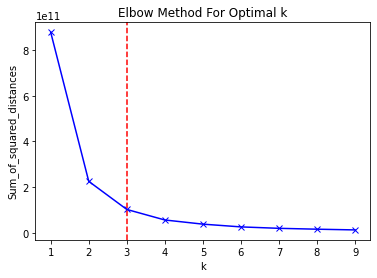

In [45]:
plt.plot(range(1,10), sse, 'bx-')
plt.axvline(3, color='r', ls='--')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


base on the results of kneeLocator and Elbow method I will choose 3 clusters

In [47]:
kmeans = KMeans(n_clusters = 3)

In [48]:
kmeans.fit(df_scaled)

KMeans(n_clusters=3)

In [49]:
df_scaled['Clusters'] = kmeans.fit_predict(df_scaled)

In [50]:
df_sample['Clusters'] = df_scaled['Clusters']

In [51]:
df_sample.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Clusters
149478,2008,1,25,5,1926.0,1815,2222.0,2130,AA,658,...,8.0,0,N,0,0.0,0.0,1.0,0.0,51.0,0
620288,2008,4,6,7,2123.0,2045,2246.0,2208,OO,6812,...,20.0,0,N,0,0.0,0.0,0.0,0.0,38.0,1
111366,2008,1,2,3,2116.0,2050,2236.0,2218,FL,418,...,8.0,0,N,0,18.0,0.0,0.0,0.0,0.0,1
1851647,2008,12,27,6,947.0,925,1112.0,1054,EV,5042,...,12.0,0,N,0,10.0,0.0,0.0,0.0,8.0,1
1648008,2008,11,23,7,1750.0,1722,1949.0,1939,XE,3112,...,18.0,0,N,0,0.0,0.0,0.0,0.0,0.0,2


I'm going to explore the data to see  patterns that explain  the cluster distribution

<AxesSubplot:xlabel='Clusters', ylabel='ArrDelay'>

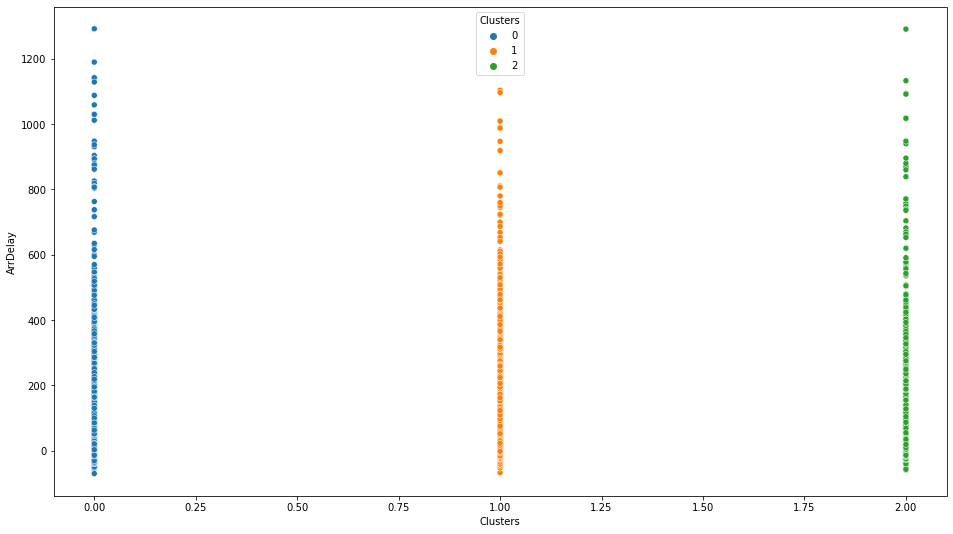

In [52]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_sample, x="Clusters", y="ArrDelay", hue="Clusters",palette=["C0", "C1", "C2"])

In [53]:
group = df_sample.groupby('Clusters')['ArrDelay'].agg(lambda x: x.count()).reset_index(name='AcumDelay')

group

,Clusters,AcumDelay
0,0,67826.0
1,1,64950.0
2,2,60899.0


there is no signifantly diference of the cluster agrupation by ArrDelay

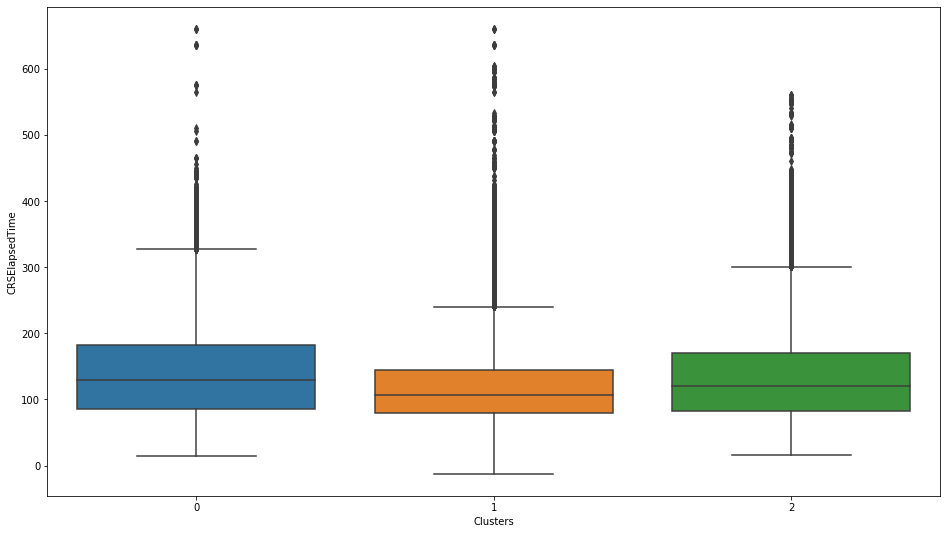

In [54]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df_sample["Clusters"], y=df_sample["CRSElapsedTime"])
plt.show()


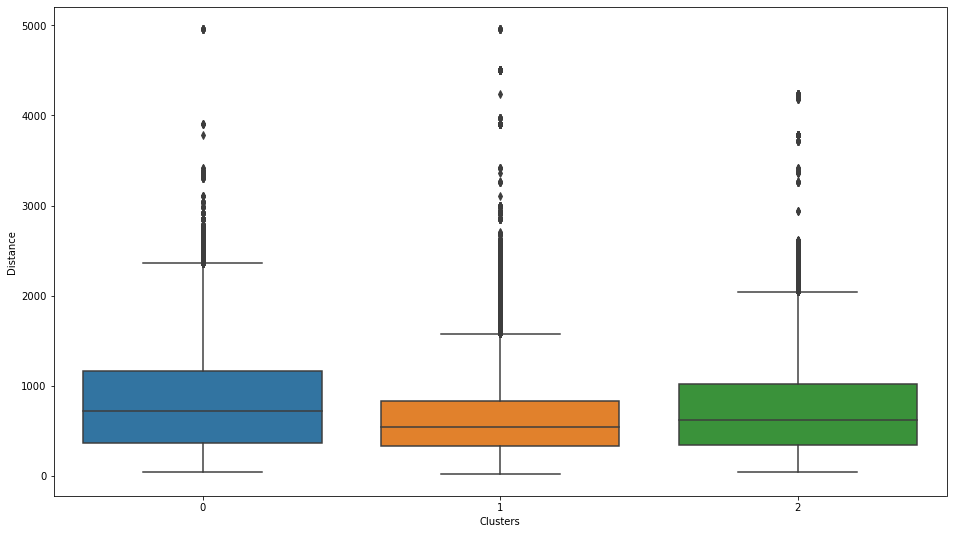

In [55]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df_sample["Clusters"], y=df_sample["Distance"])
plt.show()


We can oberve that the flights with large Elapsed time  are in cluster 3 , mid elapsed time in cluster 2 , and short elapsed time in cluster 1

C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distr

<AxesSubplot:ylabel='Density'>

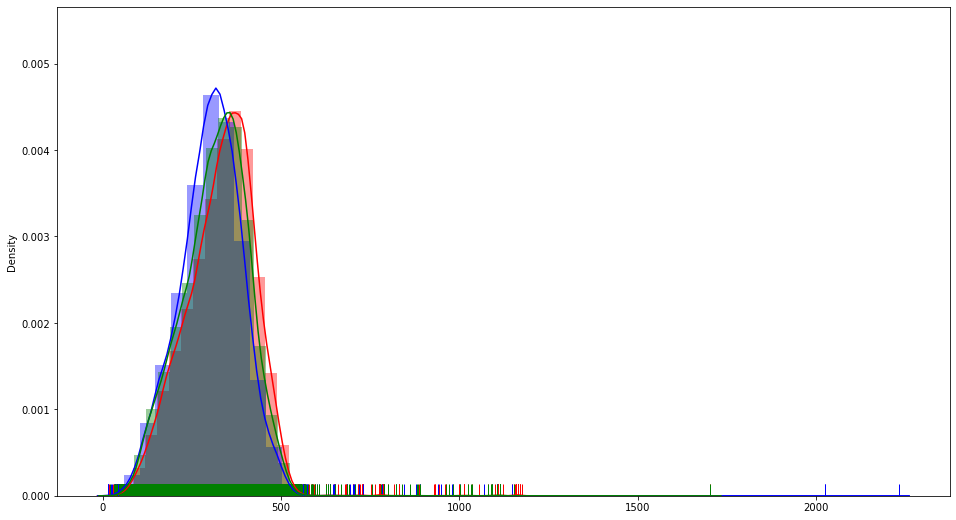

In [56]:
## we try to explore if there is a relation between the average speed of the flights and the cluster partition
elapsedTimeH = df_sample['ActualElapsedTime'].apply(lambda x: x/60)
df_sample['AvgSpeed']=df_sample['Distance']/elapsedTimeH

d2= df_sample[['FlightNum','AvgSpeed','Clusters']]
Cluster_1 = d2.loc[d2['Clusters'] == 0]
Cluster_2= d2.loc[d2['Clusters'] == 1]
Cluster_3= d2.loc[d2['Clusters'] == 2]
plt.figure(figsize=(16,9))
sns.distplot(Cluster_1[['AvgSpeed']], rug=True,color="r")
sns.distplot(Cluster_2[['AvgSpeed']], rug=True,color="b")
sns.distplot(Cluster_3[['AvgSpeed']], rug=True,color="g")

we can observe that even though the relationship is quite low , the clusters are distributed by Low-avg speed(cluster 1 ,red)
mid-avg speed (cluster 2, blue),high-avg speed(cluster 3, green)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Count'>

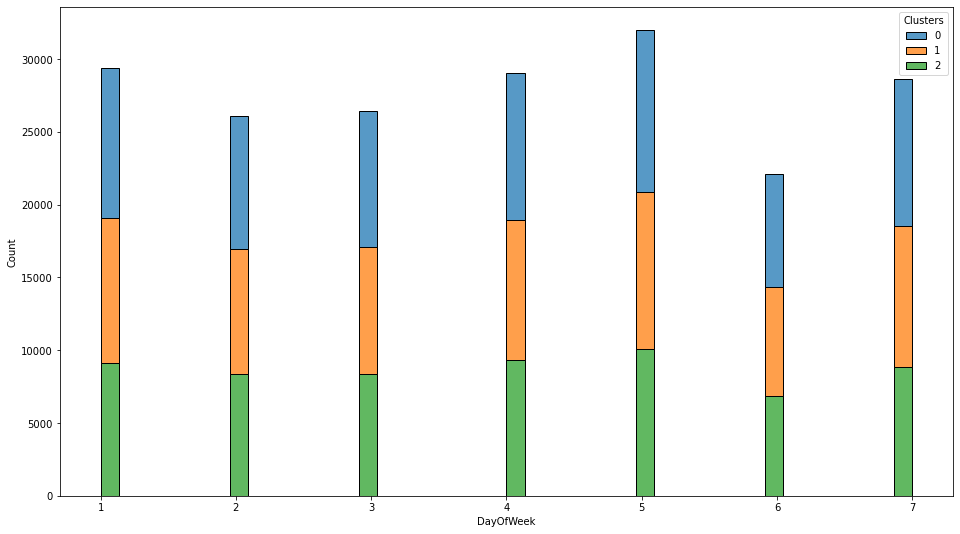

In [57]:
plt.figure(figsize=(16,9))
sns.histplot(data=df_sample, x="DayOfWeek",multiple="stack",hue='Clusters',palette=["C0", "C1", "C2"])

<AxesSubplot:xlabel='CancellationCode', ylabel='Clusters'>

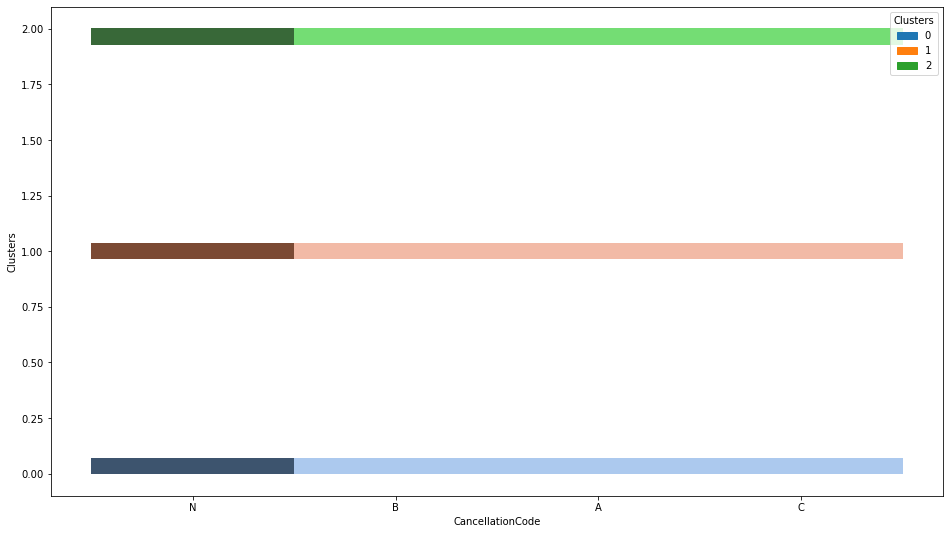

In [58]:
plt.figure(figsize=(16,9))
sns.histplot(data=df_sample, x="CancellationCode",y='Clusters',hue='Clusters',palette=["C0", "C1", "C2"])


apart from the average speed and distance and CRSElapsedTime we cannot see any other classification

***Using PCA***

In [64]:
df_scaledPCA = df_sample_processed.copy()

In [65]:

sc=StandardScaler()

df_scaledPCA[numeric_data.columns]=sc.fit_transform(df_scaled[numeric_data.columns])


In [66]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaledPCA)

In [67]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [70]:
principalDf

,principal component 1,principal component 2
0,1132.064535,94.183142
1,-1790.368031,-136.692853
2,-3670.278234,-53.977769
3,-2693.025615,74.973104
4,3349.533189,90.051477
...,...,...
193670,2102.340927,80.751552
193671,-1447.131116,-43.592427
193672,-2793.855843,101.196906
193673,2017.555756,59.748224


Text(0, 0.5, 'PCA 2')

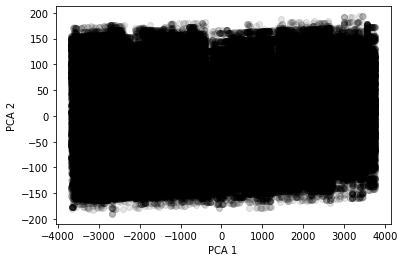

In [71]:
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

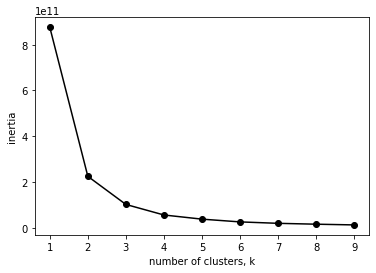

In [73]:
ks = range(1, 10)
inertias = []
for k in ks:
    
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(principalDf.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


we observe that same as without PCA the optimal K is 3

In [68]:
kmeans = KMeans(n_clusters = 3)

In [69]:
kmeans.fit(principalDf)

KMeans(n_clusters=3)

In [76]:
principalDf['Clusters'] = kmeans.fit_predict(principalDf)

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

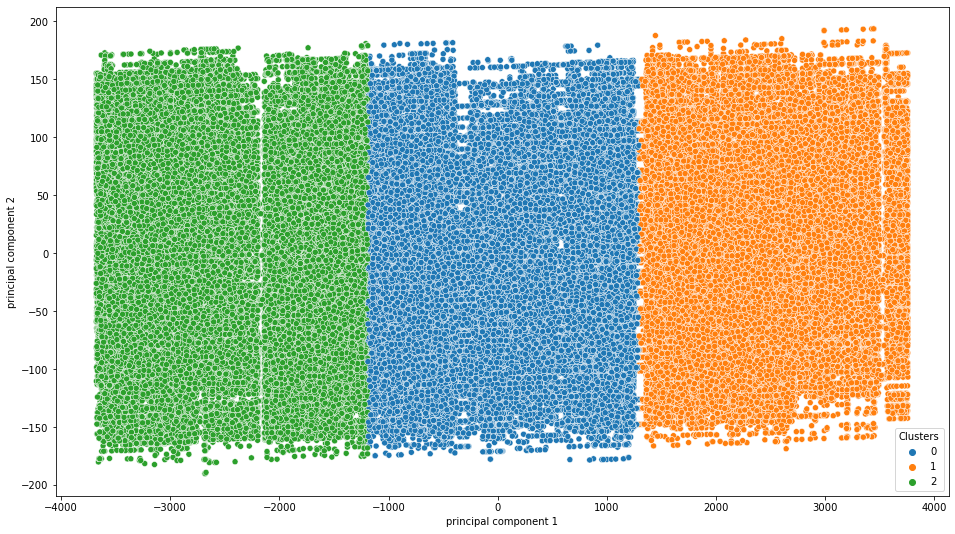

In [77]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=principalDf, x="principal component 1", y="principal component 2", hue="Clusters",palette=["C0", "C1", "C2"])

In [78]:
df_segment=pd.concat([df_sample.reset_index(drop= True),pd.DataFrame(principalComponents)],axis=1)


In [79]:
df_segment['PCACluster']=kmeans.labels_

In [80]:
df_segment

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Clusters,AvgSpeed,0,1,PCACluster
0,2008,1,25,5,1926.0,1815,2222.0,2130,AA,658,...,0.0,0.0,1.0,0.0,51.0,0,445.344828,1132.064535,94.183142,0
1,2008,4,6,7,2123.0,2045,2246.0,2208,OO,6812,...,0.0,0.0,0.0,0.0,38.0,1,326.024096,-1790.368031,-136.692853,2
2,2008,1,2,3,2116.0,2050,2236.0,2218,FL,418,...,18.0,0.0,0.0,0.0,0.0,1,339.000000,-3670.278234,-53.977769,2
3,2008,12,27,6,947.0,925,1112.0,1054,EV,5042,...,10.0,0.0,0.0,0.0,8.0,1,226.588235,-2693.025615,74.973104,2
4,2008,11,23,7,1750.0,1722,1949.0,1939,XE,3112,...,0.0,0.0,0.0,0.0,0.0,2,266.722689,3349.533189,90.051477,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193670,2008,6,17,2,1737.0,1730,1849.0,1830,WN,42,...,0.0,3.0,12.0,0.0,4.0,2,199.166667,2102.340927,80.751552,1
193671,2008,4,28,1,824.0,810,1003.0,940,US,1904,...,14.0,0.0,9.0,0.0,0.0,1,221.818182,-1447.131116,-43.592427,2
193672,2008,1,5,6,2005.0,1955,2125.0,2127,YV,2650,...,0.0,0.0,0.0,0.0,0.0,1,322.500000,-2793.855843,101.196906,2
193673,2008,3,22,6,1613.0,1605,2020.0,2034,CO,210,...,0.0,0.0,0.0,0.0,0.0,2,449.197861,2017.555756,59.748224,1


<AxesSubplot:xlabel='PCACluster', ylabel='ArrDelay'>

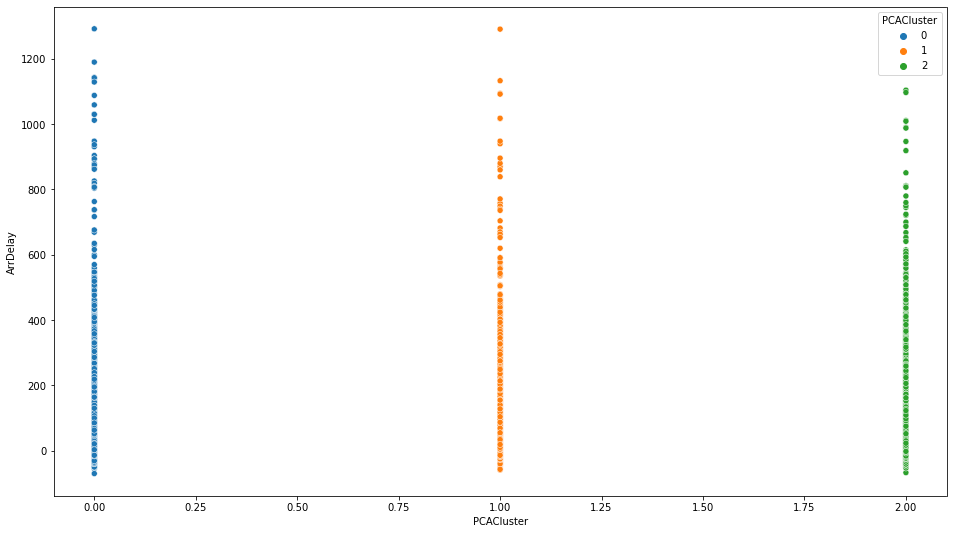

In [81]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_segment, x="PCACluster", y="ArrDelay", hue="PCACluster",palette=["C0", "C1", "C2"])

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Count'>

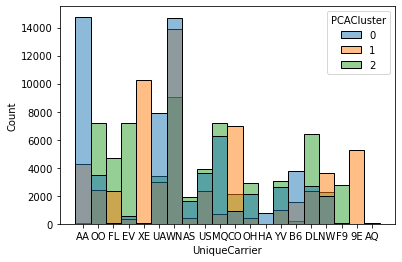

In [82]:
sns.histplot(data=df_segment, x="UniqueCarrier",hue='PCACluster',palette=["C0", "C1", "C2"])

<AxesSubplot:xlabel='Clusters', ylabel='ArrDelay'>

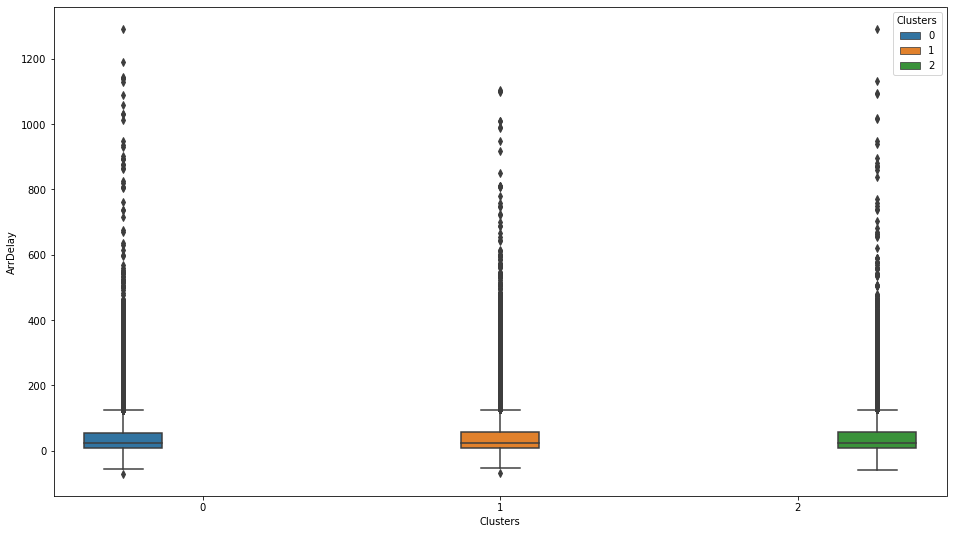

In [84]:
plt.figure(figsize=(16,9))
sns.boxplot(data=df_sample, x="Clusters", y="ArrDelay", hue="Clusters",palette=["C0", "C1", "C2"])

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Count'>

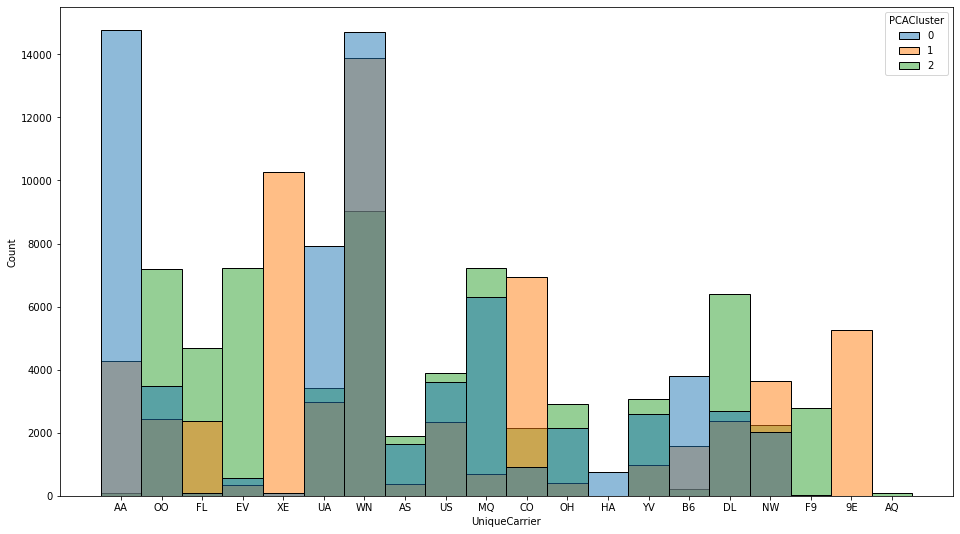

In [85]:
plt.figure(figsize=(16,9))
sns.histplot(data=df_segment, x="UniqueCarrier",hue='PCACluster',palette=["C0", "C1", "C2"])

C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adria\anaconda3\lib\site-packages\seaborn\distr

<AxesSubplot:ylabel='Density'>

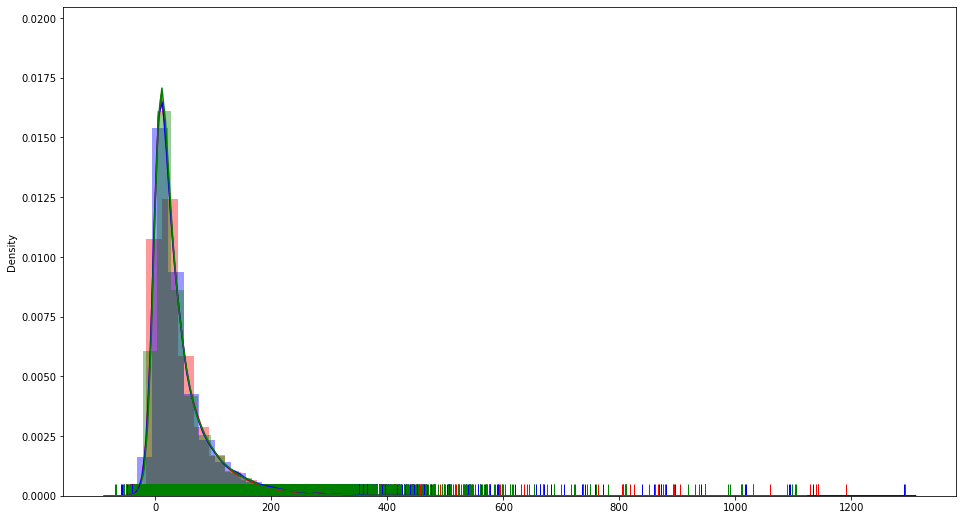

In [87]:
d2= df_segment[['FlightNum','ArrDelay','PCACluster']]
Cluster_1 = d2.loc[d2['PCACluster'] == 0]
Cluster_2= d2.loc[d2['PCACluster'] == 1]
Cluster_3= d2.loc[d2['PCACluster'] == 2]
plt.figure(figsize=(16,9))
sns.distplot(Cluster_1[['ArrDelay']], rug=True,color="r")
sns.distplot(Cluster_2[['ArrDelay']], rug=True,color="b")
sns.distplot(Cluster_3[['ArrDelay']], rug=True,color="g")

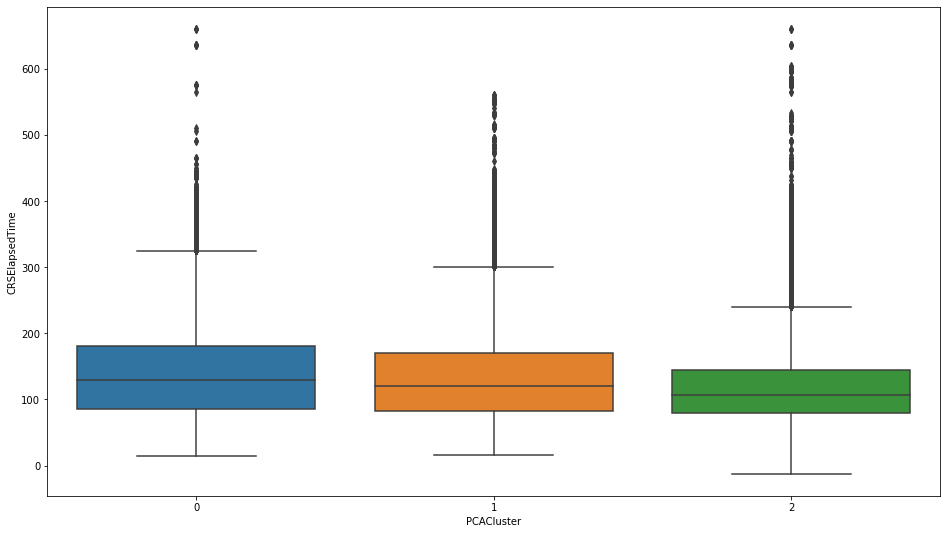

In [88]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df_segment["PCACluster"], y=df_segment["CRSElapsedTime"])
plt.show()


But  the cluster distribution still unclear

# Nivell 2
## Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.



In [75]:
df_scaled2 = df_scaled.sample(19367)
df_scaledPCA = df_scaled2.copy()




pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaledPCA)

principalDfHC = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [77]:
principalDfHC

,principal component 1,principal component 2
0,1569.264486,74.812783
1,1465.981512,-15.217007
2,-1731.156626,48.808854
3,-2947.096521,-78.870299
4,671.848162,-81.439887
...,...,...
19362,-1666.034469,-32.125339
19363,1548.048953,19.303268
19364,-2964.589999,103.868409
19365,-1792.568122,124.306020


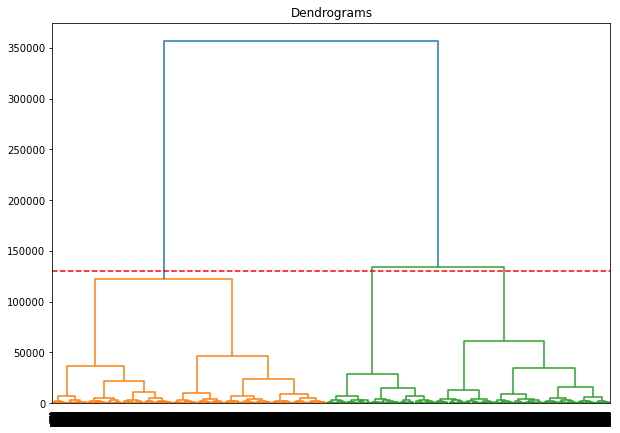

In [60]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(principalDf, method='ward'))
plt.axhline(y=130000, color='r', linestyle='--')


In [78]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(principalDfHC)

array([0, 0, 1, ..., 2, 1, 2], dtype=int64)

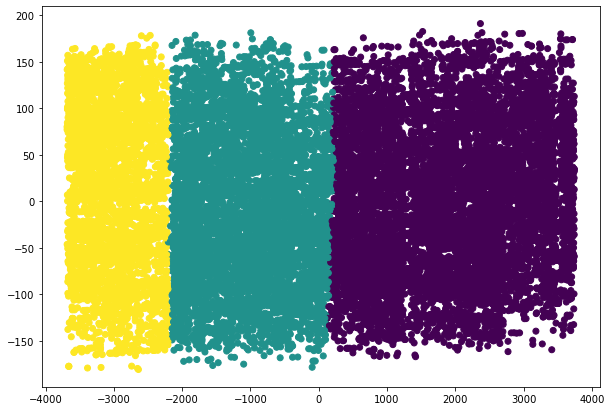

In [80]:
plt.figure(figsize=(10, 7))  
plt.scatter(principalDfHC['principal component 1'], principalDfHC['principal component 2'], c=cluster.labels_) 

## Nivell 3
### Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.


In [70]:
kmeans_sil = silhouette_score(principalDf,kmeans.labels_).round(2)

In [71]:
kmeans_sil

0.58

In [81]:
hierarchical_clustering_sil = silhouette_score(principalDfHC,cluster.labels_).round(2)

In [96]:
hierarchical_clustering_sil

0.56

the results of silhouette score shows that the best method approach is Kmeans although no significant diference